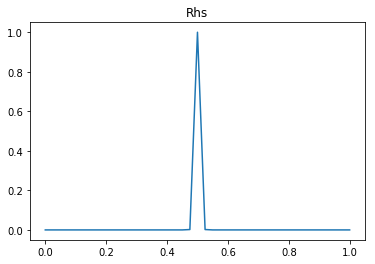

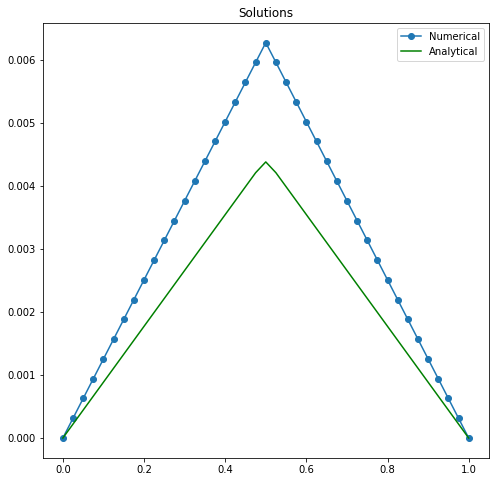

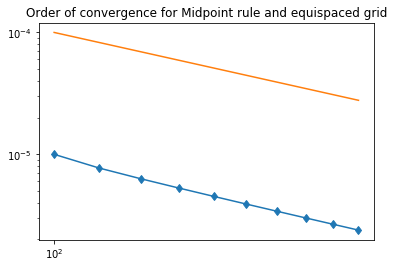

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.special import erf
from math import pi
import warnings
warnings.filterwarnings('ignore')

def rhs1(x):
    return np.sin(pi*x)

def rhs2(x):
    return np.exp(-1e4*(x-0.5)**2)
    
def rhs3(x):
    return np.cos(2*pi*x)

def rhs4(x):
    return np.exp(-100*np.abs(x-0.5)**2)

    
def uex(x,rhs):
    if (rhs == rhs1):
        return np.sin(pi*x)/(pi**2)
    elif rhs == rhs2:
        return 1/20000*(100*np.sqrt(pi)*x*erf(50-100*x)+50*np.sqrt(pi)*erf(50*(2*x-1)) + 50*np.sqrt(pi)*erf(50) - 1/np.exp(2500*(1-2*x)**2) + 1/np.exp(2500))
    elif rhs == rhs3:
        return -(np.sin(pi*x)**2)/(2*pi**2)
    elif rhs == rhs4:
        return 1/200*(5*np.sqrt(pi)*(2*x-1)*erf(5-10*x) + 5*np.sqrt(pi)*erf(5)-1/np.exp(25*(1-2*x)**2) + 1/np.exp(25))
    
def convergence_plot_equispaced(mrange,quadrature,rhs):
    err = []
    for M in mrange:
        x = np.linspace(0,1,M+1)
        h = 1/M
        b = load_vector(M,rhs,x,quadrature)
        A = -np.diag(np.ones(M-2),-1) + 2*np.diag(np.ones(M-1)) - np.diag(np.ones(M-2),+1)
        A = A/h**2 #stiffness matrix
        u_int = np.linalg.solve(A,b)
        err.append(np.linalg.norm(u_int-uex(x[1:-1],rhs),np.Inf) )
    plt.figure()
    plt.loglog(mrange,err,'-d',mrange,1/mrange**2)
    plt.title('Order of convergence for ' +str(quadrature) +str(' rule and ') +str('equispaced grid'))
    plt.show()


def load_vector(M,rhs,x,quadrature):
    h = 1/M
    b = []
    if quadrature == 'Gaussian':
        for i in range(1,M):
            b.append(integrate.quad(lambda y: (1/h**2)*(y-x[i-1])*rhs(y),x[i-1],x[i])[0] + integrate.quad(lambda y: (1/h**2)*(x[i+1]-y)*rhs(y),x[i],x[i+1])[0])
    elif quadrature == 'Midpoint':
        b=rhs(x[1:-1])
    return b

######### CHOOSE RHS #########
rhs = rhs2
###########################

M = 40
h = 1/M
x = np.linspace(0,1,M+1)
A = -np.diag(np.ones(M-2),-1) + 2*np.diag(np.ones(M-1)) - np.diag(np.ones(M-2),+1)
A = A/h**2 #stiffness matrix
quad = 'Midpoint' #Gaussian or Midpoint
b = load_vector(M,rhs,x,quad)
#print(b)
u_int = np.linalg.solve(A,b)
U = np.zeros(M+1)
U[0] = 0
U[M] = 0
U[1:M] = u_int

plt.figure()
plt.plot(x,rhs(x),'-')
plt.title('Rhs')
plt.show()

plt.figure(figsize=(8,8))
plt.plot(x,U,'-o',label='Numerical')
plt.plot(x,uex(x,rhs),'g',label = 'Analytical')
plt.title('Solutions')
plt.legend()

mrange = np.arange(100,200,10)
convergence_plot_equispaced(mrange,quad,rhs)


In [46]:
print(u_int - uex(x[1:-1],rhs))

[9.21498025e-05 1.84299605e-04 2.76449407e-04 3.68599210e-04
 4.60749012e-04 5.52898815e-04 6.45048617e-04 7.37198420e-04
 8.29348222e-04 9.21498025e-04 1.01364783e-03 1.10579763e-03
 1.19794743e-03 1.29009723e-03 1.38224704e-03 1.47439684e-03
 1.56654664e-03 1.65869644e-03 1.75085261e-03 1.89178952e-03
 1.75085261e-03 1.65869644e-03 1.56654664e-03 1.47439684e-03
 1.38224704e-03 1.29009723e-03 1.19794743e-03 1.10579763e-03
 1.01364783e-03 9.21498025e-04 8.29348222e-04 7.37198420e-04
 6.45048617e-04 5.52898815e-04 4.60749012e-04 3.68599210e-04
 2.76449407e-04 1.84299605e-04 9.21498025e-05]


Solution of the Poisson equation with a non-equidistant grid from $x_0, \ldots, x_M$. Here $h_i=x_{i+1}-x_i$.

The bilinear form is symmetric, hence so is the resulting matrix (which is tridiagonal).



$\bullet$ Entries computation

$a_{j,j}= \frac{1}{h_j} + \frac{1}{h_{j-1}}$ along the diagonal

and

$a_{j,j+1}=a_{j+1,j}=- \frac{1}{h_j}$ on extradiagonal terms.


For instance, $a_{1,1}= \frac{1}{h_0} + \frac{1}{h_1} = \frac{1}{x_1-x_0} + \frac{1}{x_2-x_1}$ 



$\bullet$ Boundary conditions

Due to the Dirichlet boundary conditions, I do not discretize the boundary points $x_0$ and $x_M$, and so I solve at internal points $x_1, \ldots, x_{M-1}$. In this way I have a $(M-1) \times (M-1)$ matrix, symmetric, for the linear system.



$\bullet$ Load vector 

To build the load vector $b$, with $(b)_i=\int_0^1 f(x) \phi(x) dx$ first I wirte the integral on $\text{supp}({\phi_i}) = [x_{i-1},x_i] \cup [x_i,x_{i+1}]$, hence

\begin{align}
b_i = \int_{x_{i-1}}^{x_i} f(x) \phi(x) dx + \int_{x_i}^{x_{i+1}} f(x) \phi(x)dx
\end{align}

and in both of these region $\phi_i$ is differentiable.

Now I can use a quadrature rule to compute those integrals. I choose the trapezoidal rule, which gives

\begin{align}
b_i \approx f(x_i) \frac{h_i + h_{i-1}}{2}, \quad i=1,\ldots,M-1
\end{align}

$\bullet$ Due to the form of the second function $f_2$, which has a behaviour like a Dirac Delta centered at $x=\frac{1}{2}$, if the points are not enough in a neighbourhood of $x=\frac{1}{2}$, a method like the midpoint rule or the trapezoidal rule will not recognise the discontinuity because of an higher gradient of the function. So I need to refine the mesh around the point where the solution has an higher gradient.



$\bullet$ The use of a Gaussian quadrature rule provied the exact solution (modulo machine precision) at points. As I can see from the source code (https://github.com/scipy/scipy/blob/v1.3.2/scipy/integrate/quadpack.py#L44-L427),
the refinement is already done in that routine. So, even with equispaced nodes I obtain the solution.


$\bullet$ From the convergence plot I can see the following situations:
1. Equispaced points, Trapezoidal rule -> $O(h^2)$ only with lots of points
2. Equispaced points, Gaussian quadr -> Exact solution, even with little number of points
3. Non-equispaced, Trapezoidal rule -> $O(h^2)$
4. Non-equispaced, Guassian rule -> Exact solution

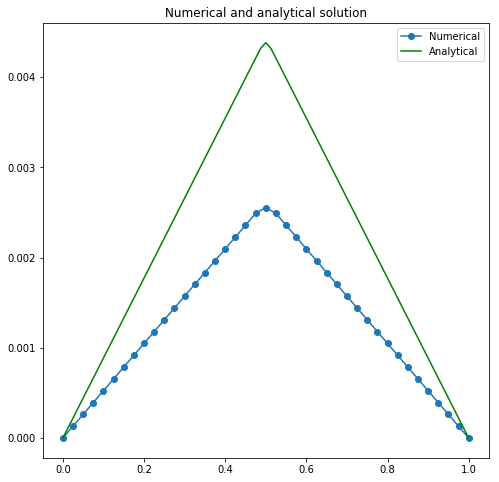

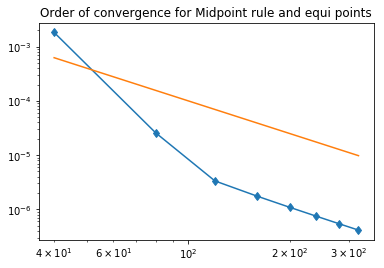

In [72]:
def convergence_plot_noneq(mrange,quadrature,nodetype,rhs):
    err = []
    for M in mrange:
        x = nodegen(M,nodetype)
        u = Fem1dPoisson(M,x,rhs,quadr)
        err.append(np.linalg.norm(u-uex(x,rhs),np.Inf) )
    plt.figure()
    plt.loglog(mrange,err,'-d',mrange,1/mrange**2)
    plt.title('Order of convergence for ' +str(quadrature) + str(' rule and ') + str(nodetype)+ ' points') 
    plt.show()



def nodegen(M,nodtype):
    if nodtype == 'para':
        x = np.zeros(M+1)
        for i in range(0,M+1):
            # parabolic distribution of nodes
            x[i] =((i)/(M))**2
    elif nodtype == 'refine':
        
        M1 = np.int(np.floor((M)/4))
        M2 = np.int(np.floor((M)/2))
        M3 = np.int(np.floor((M)/4))

        x1 = np.linspace(0,0.40,M1)

        x2 = np.linspace(0.40 + 1/M,0.60,M2)
        x3 = np.linspace(0.60 + 1/M,1,M3+1)
        x = np.concatenate((x1,x2,x3))
    elif nodetype == 'equi':
        x = np.linspace(0,1,M+1)
    return x



def stiffassembly(M,x):
    #x = nodegen(M,nodtype) #x_0,...,x_M (M+1)
    diag = np.zeros(M-1) #x_1,...,x_M-1 (M-1)
    subd = np.zeros(M-2) 
    supr = np.zeros(M-2)
    h = np.diff(x)
    for i in range(1,M):
        diag[i-1] = 1/h[i-1] +1/h[i]

    for k in range(1,M-1):
        supr[k-1] = -1/h[k]
        subd[k-1] = -1/h[k]

    A = np.diag(subd,-1) + np.diag(diag,0) + np.diag(supr,+1)
    return A


#load vector building
def load_vector_noneq(M,rhs,x,quadrature):
    h = np.diff(x)
    b = []
    if quadrature == 'Gaussian':
        for i in range(1,M):
            b.append(integrate.quad(lambda y: (y-x[i-1])/(h[i-1])*rhs(y),x[i-1],x[i])[0] + integrate.quad(lambda y: (x[i+1]-y)/(h[i])*rhs(y),x[i],x[i+1])[0])
    elif quadrature == 'Trapezoidal':
        for i in range(1,M):
            b.append(rhs(x[i])*(h[i-1] + h[i])/2) #O(h^2)
    elif quadrature == 'Midpoint':
        for i in range(1,M):
            b.append(rhs((x[i-1] + x[i])/2)*h[i-1]/2 + rhs((x[i]+x[i+1])/2)*h[i]/2)
    return b



def Fem1dPoisson(M,x,rhs,quadr):
    A = stiffassembly(M,x)
    b = load_vector_noneq(M,rhs,x,quadr)
    u_int = np.linalg.solve(A,b)
    U = np.zeros(M+1)
    U[0] = 0
    U[1:M] = u_int
    U[M] = 0
    
    return U


######### COMPUTE THE SOLUTION
    
M = 40
nodetype = 'equi' #refine, para (parabolic), equi (equispaced)
x= nodegen(M,nodetype)
quadr = 'Midpoint'
U = Fem1dPoisson(M,x,rhs,quadr)


x = nodegen(M,nodetype)
plt.figure(figsize=(8,8))
plt.plot(x,U,'-o',label='Numerical')
xx = np.linspace(0,1,2*M+1) #to show anayltical solution
plt.plot(xx,uex(xx,rhs),'g',label = 'Analytical')
plt.legend()
plt.title('Numerical and analytical solution')
plt.show()

mrange = np.array([40,80,120,160,200,240,280,320])
convergence_plot_noneq(mrange,quadr,nodetype,rhs)

In [48]:
print(uex(x,rhs)-U) #I'm exact if I use Gaussian quadrature

[ 0.00000000e+00 -9.21498025e-05 -1.84299605e-04 -2.76449407e-04
 -3.68599210e-04 -4.60749012e-04 -5.52898815e-04 -6.45048617e-04
 -7.37198420e-04 -8.29348222e-04 -9.21498025e-04 -1.01364783e-03
 -1.10579763e-03 -1.19794743e-03 -1.29009723e-03 -1.38224704e-03
 -1.47439684e-03 -1.56654664e-03 -1.65869644e-03 -1.75085261e-03
 -1.89178952e-03 -1.75085261e-03 -1.65869644e-03 -1.56654664e-03
 -1.47439684e-03 -1.38224704e-03 -1.29009723e-03 -1.19794743e-03
 -1.10579763e-03 -1.01364783e-03 -9.21498025e-04 -8.29348222e-04
 -7.37198420e-04 -6.45048617e-04 -5.52898815e-04 -4.60749012e-04
 -3.68599210e-04 -2.76449407e-04 -1.84299605e-04 -9.21498025e-05
  0.00000000e+00]


$\bullet$ Adaptive mesh refinement 


In the case of Poisson equation, the element residual is $r_i=h(f+u_h''(x))|_{I_i}$ and since $u_h$ is by construction linear on each element $I_i$, then its $L^2$ norm is $h_i || f ||_{L^2(I_i)}$.

Thanks to the apriori estimate 
\begin{align}
|| (u - u_h)'||_{L^2(I)}^{2} \leq C \sum_{i=1}^{n} r_i^2(u_h)
\end{align}

and starting from a coarse mesh
1. Compute the element residuals $r_i$ for each element
2. Select the elements to be refined. Each $r_i$ at each iteration is stored in a vector and computed via a trapezoidal rule. Then I choose a refine parameter $\alpha \in (0,1)$ and an element $I_i$ is refined if \begin{align}
r_i >  \alpha || r_i||_{\infty}
\end{align}
and a midpoint is added to the element $I_i$ and then the vector $x$ is sorted by a standard routine.
3. Iterate up to a estabilished number of mesh points. (stopping criterion)
4. Solve the linear system with the non-uniform mesh

In [49]:
quadr = 'Midpoint'


M = 10
x = np.linspace(0,1,M+1)
while (M<40):
    
    rho = np.zeros(M) #store elemental residuals
    for k in range(0,M):
        h = x[k+1] - x[k]
        a = rhs(x[k])
        b = rhs(x[k+1])
        t = 0.5*h*(a**2 + b**2)
        rho[k] = t*h**2
        
    alfa = 0.8
    for i in range(len(rho)):
        if rho[i]>alfa*np.max(rho):
            x = np.append(x,(x[i+1]+x[i])/2)
    
    x = np.sort(x)
    M = len(x) - 1

U = Fem1dPoisson(M,x,rhs,quadr)

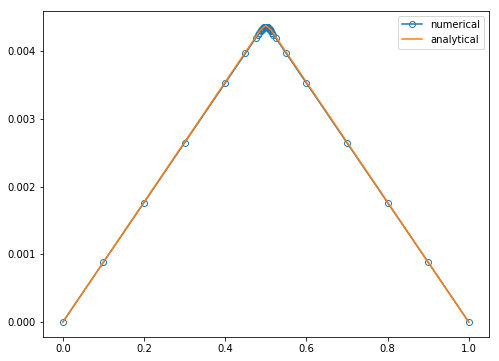

In [50]:
plt.figure(figsize=(8,6))
plt.plot(x,U,'-o',label='numerical',markerfacecolor = 'None')
plt.plot(xx,uex(xx,rhs),'-',label='analytical')
plt.legend()
plt.show()

Final comparison of the two solutions

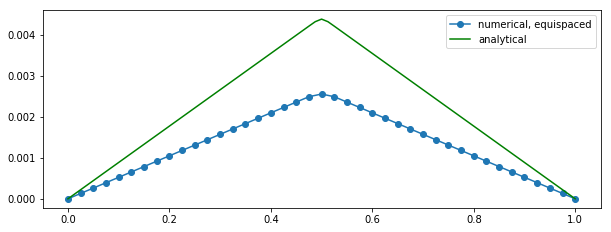

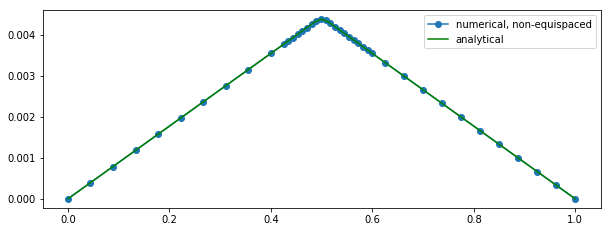

In [94]:
M =40
rhs = rhs2
quadr = 'Midpoint'
for i in range(2):
    if i == 0:
        nodetype = 'equi'
        xnr = nodegen(M,nodetype)
        unr = Fem1dPoisson(M,xnr,rhs,quadr)
    else:
        nodetype = 'refine'
        xref = nodegen(M,nodetype)
        uref = Fem1dPoisson(M,xref,rhs,quadr)

        
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(xnr,unr,'-o',label='numerical, equispaced')
xx = np.linspace(0,1,2*M+1)
plt.plot(xx,uex(xx,rhs2),'g',label='analytical')
plt.legend()
plt.show()
        
plt.figure(figsize=(10,8))
plt.subplot(2,1,2)
plt.plot(xref,uref,'-o',label='numerical, non-equispaced')
plt.plot(xx,uex(xx,rhs2),'g',label='analytical')
plt.legend()
plt.show()